In [1]:
#AWS and Braket SDK imports.
import boto3
from braket.circuits import circuit, Circuit, Gate, Instruction
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

#Cartesian product, math functions, complex numbers, Sage binary polynomials.
from itertools import product
from math import log, sqrt, pi, floor
from cmath import phase
from sage.rings.polynomial.pbori import declare_ring, Block

#Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def rotate(reg, rot_n):
    rot_n = rot_n % len(reg)
    return tuple(reg[rot_n:] + reg[:rot_n])

def xor(l_reg, r_reg):
    assert len(l_reg) == len(r_reg)
    return tuple([ l+r for l,r in zip(l_reg, r_reg) ]) 

def add(l_reg, r_reg):
    assert len(l_reg) == len(r_reg)
    c = 0
    result = list()
    for l, r in zip(l_reg, r_reg):
        s = c + l + r
        c = (l*r) + (c*(l+r))
        result.append(s)
    return tuple(result)

In [3]:
def foo(left, right, side, left_rotation = 1, right_rotation = 1):
    assert len(left) == len(right)
    assert len(right) == len(side)
    
    left = rotate(left, left_rotation)
    left = add(left, right)
    left = xor(left, side)
    right = rotate(right, right_rotation)
    right = xor(left, right)
    return (left, right)

In [4]:
F = GF(2) #Modulo 2 Field - F2
O, I = F(0), F(1) #F2 elements - 0,1

def encrypt(K1, K2, PT1, PT2, rounds, left_rotation = 1, right_rotation = 1):
    word_size = len(K1)
    assert len(K2) == word_size
    assert len(PT1) == word_size
    assert len(PT2) == word_size

    nonces = list( product( (O, I), repeat = word_size ) ) #This generates consecutive integers in binary representation (nonces)
    assert rounds < len(nonces)
    
    for i, nonce in zip( range(rounds - 1), nonces):
        PT1, PT2 = foo(PT1, PT2, K2, left_rotation, right_rotation)
        K1, K2 = foo(K1, K2, nonce, left_rotation, right_rotation)
    
    PT1, PT2 = foo(PT1, PT2, K2, left_rotation, right_rotation)
    
    return (PT1, PT2)   

In [5]:
R = declare_ring( [Block('k', 4), Block('p', 4)] )

K = R.gens()[0:4]
P = R.gens()[4:8]
K1 = K[0:2]
K2 = K[2:4]
PT1 = P[0:2]
PT2 = P[2:4]

In [6]:
rounds = int(2)
CP1, CP2 = encrypt(K1, K2, PT1, PT2, rounds)
CP = (*CP1, *CP2) #Ciphertext Polynomials

print(f'Cipher Text Polynomials:')
for i, c in enumerate(CP):
    print(f"c({i}) = {c}")

Cipher Text Polynomials:
c(0) = k(1) + p(0) + p(1)*p(2) + p(1) + p(2)
c(1) = k(0) + k(1)*k(2) + k(2)*k(3) + k(2)*p(0) + k(2)*p(1)*p(2) + k(2)*p(3) + k(3)*p(1) + k(3)*p(2) + k(3)*p(3) + p(0)*p(1) + p(0)*p(2) + p(0)*p(3) + p(0) + p(1)*p(2)*p(3) + p(1)*p(2) + p(1)*p(3) + p(1) + p(2)*p(3)
c(2) = k(1) + k(3) + p(1) + p(3)
c(3) = k(0) + k(1)*k(2) + k(2)*k(3) + k(2)*p(0) + k(2)*p(1)*p(2) + k(2)*p(3) + k(2) + k(3)*p(1) + k(3)*p(2) + k(3)*p(3) + p(0)*p(1) + p(0)*p(2) + p(0)*p(3) + p(0) + p(1)*p(2)*p(3) + p(1)*p(2) + p(1)*p(3) + p(2)*p(3) + p(2) + p(3)


In [7]:
K1 = (I, O) 
K2 = (I, O) #Our secret key, which we will try to recover is (1,0,1,0)
PT1 = (I, O)
PT2 = (O, I)
rounds = 2
CT1, CT2 = encrypt(K1, K2, PT1, PT2, rounds)
CT = (*CT1, *CT2)

In [8]:
K1 = K[0:2] #Unknown
K2 = K[2:4] #Unknown
PT1 = (I, O)
PT2 = (O, I)
ES = [ cp(*K1, *K2, *PT1, *PT2) + ct for cp, ct in zip(CP, CT) ] #Equation System

In [9]:
my_bucket = "amazon-braket-bucket-name" # the name of the bucket
my_prefix = "folder-name" # the name of the folder in the bucket

s3_folder = (my_bucket, my_prefix)
#sv_device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
#ionq_device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
device = LocalSimulator()

In [10]:
@circuit.subroutine(register=True)
def toffoli(controls, target):
    assert len(controls) == 2
    circ = Circuit()
    c0, c1 = controls
    circ.h(target)
    circ.cnot(c1, target)
    circ.ti(target)
    circ.cnot(c0, target)
    circ.t(target)
    circ.cnot(c1, target)
    circ.ti(target)
    circ.cnot(c0, target)
    circ.t(c1)
    circ.t(target)
    circ.cnot(c0, c1)
    circ.h(target)
    circ.t(c0)
    circ.ti(c1)
    circ.cnot(c0, c1)
    return circ

In [11]:
def pow_2_divisor(n): #Returns highest power of 2 which divides given integer
    n = int(n) #Conversion from Sage-integer to standard int
    return int(log(n & (~(n - int(1))), 2))

In [12]:
@circuit.subroutine(register=True)
def mcz(controls, theta = pi):
    lc = len(controls)
    circ = Circuit()
    if lc > 1:
        circ.mcz(controls[:-1], theta/2) #MCZ gate with one less control qubit
        theta = theta / pow(2, lc-1)
        circ.cnot(controls[-2], controls[-1])
        for i in range(1, pow(2, lc-1)):
            circ.rz(controls[-1], theta*pow(-1,i))
            index = pow_2_divisor(i)
            circ.cnot(controls[index], controls[-1])
        circ.rz(controls[-1], theta)
    else:
        circ.rz(controls[0], theta) # Base case, when there is only one qubit left
    return circ

In [13]:
@circuit.subroutine(register=True)
def mcx(controls, target):
    L = len(controls)
    circ = Circuit()
    if L == 0:
        circ.x(target)
    elif L == 1:
        circ.cnot(*controls, target)
    elif L == 2:
        circ.toffoli(controls, target)
    else:
        circ.h(target)
        circ.mcz(controls + [target])
        circ.h(target)
    return circ

In [14]:
@circuit.subroutine(register=True)
def es_filter(ES, v_num):
    circ = Circuit()
    for i, eq in enumerate(ES):
        for term in eq.terms(): #list of monomials in a polynomial
            variables = [v.index() for v in term] # list of variables present in monomial
            circ.mcx(variables, i + v_num) #those variables corespond with control qubits
    return circ

In [15]:
@circuit.subroutine(register=True)
def es_oracle(ES, v_num): #v_num - number of variable qubits, it is necessery to speciffy as it is starting index for ancilla qubits
    circ = Circuit()
    circ.es_filter(ES, v_num)
    mcz_list = list(range(v_num, v_num + len(ES))) #List of flipped ancilla qubits 
    circ.mcz(mcz_list)     
    circ.es_filter(ES, v_num)
    return circ

In [16]:
@circuit.subroutine(register=True)
def grover_mirror(qubits):
    circ = Circuit()
    circ.h(qubits)
    circ.x(qubits)
    circ.mcz(qubits)
    circ.x(qubits)
    circ.h(qubits)
    return circ

In [17]:
@circuit.subroutine(register=True)
def grover(ES, v_num, rounds=None, solutions=None):
    if rounds is None:
        if solutions:
            solution_space = pow(2, v_num)
            rounds = floor( pi/4 * sqrt(solution_space / solutions) ) 
        else: rounds = 1
    circ = Circuit()
    circ.h(range(v_num))    
    for i in range(rounds):
        circ.es_oracle(ES, v_num)
        circ.grover_mirror(range(v_num))
    return circ

In [18]:
for i in range(len(ES)):
    ES[i] = ES[i] + I

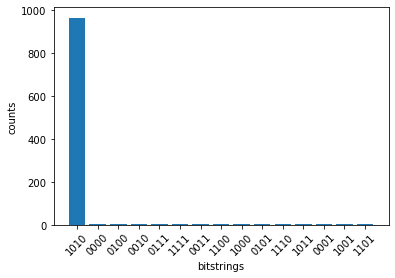

In [33]:
grover_solver_circuit = Circuit().grover(ES, 4, solutions = 1)
task = device.run(grover_solver_circuit, shots=int(1000))
result = task.result()
counts = result.measurement_counts
variable_bits = [c[0:4] for c in counts.keys()]
plt.bar(variable_bits, counts.values())
plt.xlabel('bitstrings');
plt.ylabel('counts');
_ = plt.xticks(rotation = 45)